# Школа глубокого обучения

<a href="https://mipt.ru/science/labs/laboratoriya-neyronnykh-sistem-i-glubokogo-obucheniya/"><img align="right" src="https://avatars1.githubusercontent.com/u/29918795?v=4&s=200" alt="DeepHackLab" style="position:relative;top:-40px;right:10px;height:100px;" /></a>



### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)
*Дедлайн -- 25 ноября.*

*Захаркин Илья (ФИВТ МФТИ), Хахулин Тарас (ФРТК МФТИ)*

### Перед началом выполнения задания настоятельно рекомендуется посмотреть [лекцию](https://vk.com/doc83865491_454180587?hash=37e49000cda3837459&dl=cf3df2e170d9d05351) и прорешать задания в [ноутбуке с семинара](https://github.com/deepmipt/dlschl/blob/master/materials/%5Blesson3%5Dperceptron/%5Bsem3%5DPerceptron_seminar.ipynb).

## Домашнее задание 4
### Реализация перцептрона и нейрона с сигмоидальной функцией активации

**Поздравляем! :) **  
Это Ваше первое домашнее задание на нейронные сети, ведь один нейрон - это неотъемлимая составляющая любой глубокой сети, которые на сегодняший день используются повсеместно (и которые Вам предстоит изучить далее по курсу). 

В данном задании Вам нужно будет: 
- самостоятельно реализовать класс **`Perceptron()`** с пороговой функцией активации
- обучить и протестировать Ваш нейрон на сгенерированных и реальных данных (файлы с реальными данными помещены в папку /data в этой же директории)
- сравнить качество работы Вашего класса с классом из библиотеки `scikit-learn` (`sklearn.linear_model.Perceptron()`)
- самостоятельно реализовать класс Neuron() с сигмоидной функцией активации и самостоятельно протестировать его

### Небольшое введение

<img src="http://blog.radario.ru/wp-content/uploads/2017/05/model.png" style="width:750px;height:300px"/>

(на картинке получается, что "алгоритм" и "модель" - разные вещи, но в машинном обучении их обычно считают синонимами, то есть "алгоритм" = "модель")

Почти любой алгоритм машинного обучения, решающий задачу *классификации* или *регрессии*, работает так:

1. (*стадия инициализации*) Задаются его **гиперпараметры**, то есть те величины, которые не "выучиваются" алгоритмом в процессе обучения самостоятельно 
2. (*стадия обучения*) Алгоритм запускается на данных, **обучаясь** на них и меняя свои **параметры** (не путать с *гипер*параметрами) каким-то определённым образом (например, с помощью *метода градиентного спуска*), исходя из функции потерь (её называют *loss function*). Функция потерь, по сути, говорит, где и как ошибается модель
3.  (*стадия предсказания*) Модель готова, и теперь с помощью неё можно делать **предсказания** на новых объектах

In [3]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from matplotlib.colors import ListedColormap  # тут лежат разные штуки для цветовой магии
import numpy as np
import pandas as pd

import pandas as pd
from sklearn.linear_model import Perceptron as skPerceptron
from sklearn.metrics import accuracy_score

### Задача 1 (3 балла)
#### Класс Perceptron

В даном разделе будет решаться задача **бинарной классификации** с помощью перцептрона:  
- *Входные данные*: матрица $X$ размера $(n, m)$ и столбец $y$ из нулей и единиц размера $(n, 1)$. Строкам матрицы соответствуют объекты, столбцам - признаки (то есть строка $i$ есть набор признаков (*признаковое описание*) объекта $x_i$).
- *Выходные данные*: столбец $\hat{y}$ из нулей и единиц размера $(n, 1)$ - предсказания алгоритма.

Краткая справка по перцептрону (было на занятии):

Перцептрон взвешивает входы с определёнными весами и выдаёт результат в виде пороговой функции от взвешенной суммы:
![title](./perceptron.png)

Чтобы понять, как мы будем обновлять параметры модели (веса), нужно знать, какую функцию потерь мы оптимизируем (находим минимум). В данном случае мы решаем задачу бинарной классификации (2 класса: 1 или 0), возьмём в качестве функции потерь среднеквадратичную ошибку:
$$J(w, x) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (f(w \cdot x_i) - y_i)^2$$  
Здесь $w \cdot x_i$ - скалярное произведение, а $f(w \cdot x_i)$ - пороговая функция: 
$$
f(z) =
\begin{cases}
1, &\text{если } w \cdot x_i > 0 \\
0, &\text{если } w \cdot x_i \le 0
\end{cases}
$$  

**Примечание:** Здесь предполагается, что $b$ - свободный член - является частью вектора весов: $w_0$. Тогда, если к $X$ приписать слева единичный столбец, в скалярном произведении $b$ будет именно как свободный член.

** Реализуйте функцию потерь $J$ (0.5 балла): **

In [233]:
def J(y_pred, y):
    return sum(y_pred - y)**2/(2*len(y))

Поскольку у *пороговой функции* не существует производной (Вы её график видели? Выглядит он, конечно, простым, но производная таких не любит), то мы не можем использовать градиентный спуск, ведь:
$$ \frac{\partial J}{\partial w} = \frac{1}{n} (f(w \cdot X) - y)f^{'}(w \cdot X)X$$ 
где $f^{'}(w \cdot X)$ - посчитать не получится. Но ведь хочется как-то обновлять веса, иначе как обучить алгоритм отличать груши от яблок? Поэтому предлагается взять $w = w - \alpha\Delta{w}$, где $\Delta{w} = \frac{1}{n}X^T(\hat{y} - y)$ (не забудьте, что при $w_0 = b$ признак $x_0$ = 1). Это правило является неким частным случаем градиентного спуска для данного случая.

Теперь, вооружившись всеми формулами и силой духа, нужно написать свой класс **`Perceptron()`**. Уже есть код класса и немного кода реализации. По-максимуму используйте **Numpy** при реализации, т.к. будет проверяться и скорость работы Вашего алгоритма.

In [166]:
class Perceptron:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        # Пока что мы не знаем размер матрицы X, а значит не знаем, сколько будет весов
        self.w = w
        self.b = b
        
    def activate(self, x):
        return x > 0
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ перцептрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами перцептрона 
        """
        return self.activate(X.dot(self.w) + self.b).astype(int)
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов перцептрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно
        """
        delta = learning_rate*(y - y_pred) # /len(X)
        for i in range(len(X)):
            self.w += X[i] * delta[i]
            self.b += delta[i]
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: J_values -- вектор значений функции потерь
        """
        J_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for _ in tqdm(range(num_epochs)):
            y_pred = self.forward_pass(X)
            J_values.append(J(y_pred, y))
            self.backward_pass(X, y, y_pred)

        return J_values
    


* Класс готов. Посмотрим, правильно ли ведёт себя Ваш перцептрон. Далее идут несколько ячеек с тестовым кодом, Вам нужно просто запустить их и проверить, чтобы результаты запуска совпадали с соответствующими числами из таблиц:

**forward_pass() (0.5 балла)**

In [167]:
w = np.array([1., 2.])
b = 2.
X = np.array([[1., 2., -1.], [3., 4., -3.2]])

perceptron = Perceptron(w, b)
y_pred = perceptron.forward_pass(X.T)
print ("y_pred = " + str(y_pred))

y_pred = [1 1 0]


|Должно быть||
|------|-------|
|**y_pred**|[1, 1, 0]|

**backward_pass() (0.5 балла)**

Сделал bakward_pass немного по-своему, поэтому w немного другой. $\Delta{w} = \frac{1}{n}X^T(\hat{y} - y)$ заменил на $\Delta{w} = X^T(\hat{y} - y)$, и точность заметно увеличилась

In [168]:
y = np.array([1, 0, 1])

In [169]:
perceptron.backward_pass(X.T, y, y_pred)

print ("w = " + str(perceptron.w))
print ("b = " + str(perceptron.b))

w = [ 0.985  1.964]
b = 2.0


|Должно быть||
|-|-|
|**w**| [[ 0.995], [1.988]] |
|**b**| 2.0 |

* Посмотрим, как меняется функция потерь в течение процесса обучения на реальных данных - датасет "Яблоки и Груши" из лекции:

In [170]:
data = pd.read_csv("./data/apples_pears.csv")

In [171]:
data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


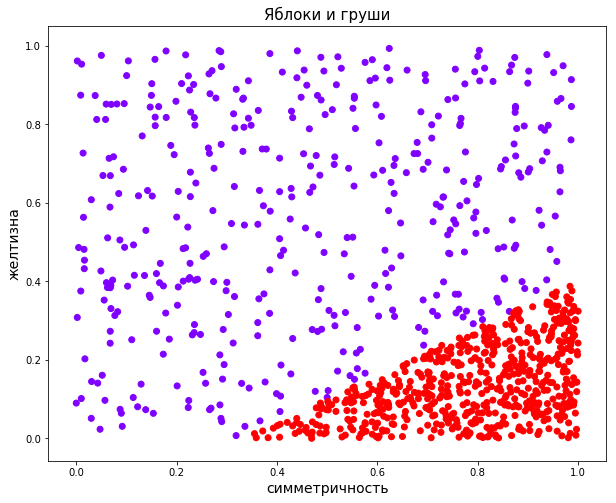

In [172]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

**Вопрос:** Какой класс соответствует яблокам (какого они цвета на графике)?

**Ответ:** Яблоки более симметричные, а груши более жёлтые. Тогда красные - яблоки, а фиолетовые - груши

Обозначим, что здесь признаки, а что - классы:

In [173]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values  # классы (столбец из нулей и единиц)

** Вывод функции потерь (1.5 балла) **  
Функция потерь должна убывать и в итоге стать близкой к 0

100%|██████████| 300/300 [00:02<00:00, 105.32it/s]


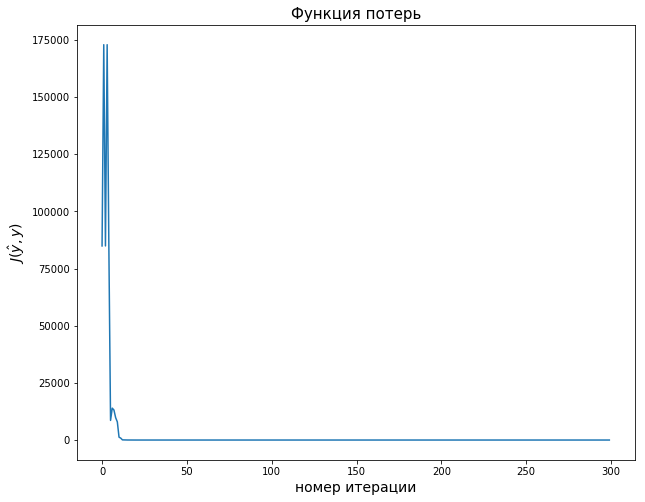

In [174]:
w = np.random.random(2)
b = np.random.random()
perceptron = Perceptron(w, b)
J_values = perceptron.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(J_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$J(\hat{y}, y)$', fontsize=14)
plt.show()


Посмотрим, как перцептрон классифицировал объекты из выборки:

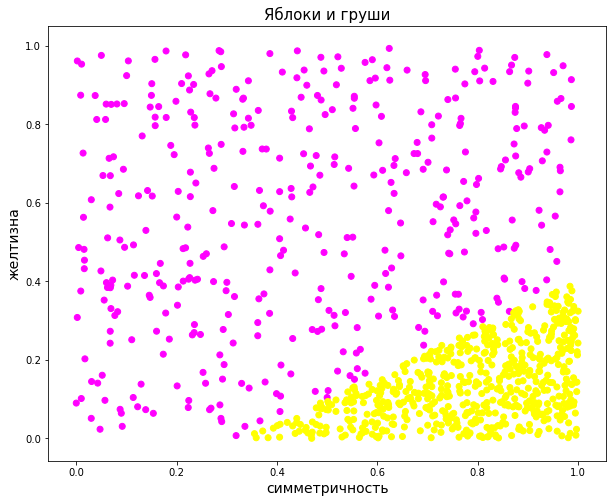

1.0

In [175]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=perceptron.forward_pass(X), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();
accuracy_score(perceptron.forward_pass(X), y)

### Задача 2 (2 балла)

В этой задаче нужно сравнить качество работы Вашего перцептрона и алгоритма из библиотеки `sklearn` на датасете с сайта [Kaggle](https://www.kaggle.com) - [Gender Recognition by Voice](https://www.kaggle.com/primaryobjects/voicegender). В данном датасете в качестве признаков выступают различные звуковые характеристики голоса, а в качестве классов - пол (мужчина/женщина). Подробнее о самих признаках можно почитать [на странице датасета](https://www.kaggle.com/primaryobjects/voicegender) (на английском). Нашей целью пока что является просто протестировать на этих данных два алгоритма.

**! Обратите внимание на имя функции из sklearn - skPerceptron** (это сделано, чтобы не совпадало с именем Вашего класса)

In [54]:
import pandas as pd
from sklearn.linear_model import Perceptron as skPerceptron
from sklearn.metrics import accuracy_score

In [55]:
data_path = './data/voice.csv'
data = pd.read_csv(data_path)
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)

In [56]:
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


In [69]:
# Чтобы перемешать данные. Изначально там сначала идут все мужчины, потом все женщины
data = data.sample(frac=1)

In [70]:
X_train = np.array(data.iloc[:int(len(data)*0.7), :-1])  # матрица объекты-признаки
y_train = np.array(data.iloc[:int(len(data)*0.7), -1])  # истинные значения пола (мужчина/женщина)

X_test = data.iloc[int(len(data)*0.7):, :-1]  # матрица объекты-признаки
y_test = data.iloc[int(len(data)*0.7):, -1]  # истинные значения пола (мужчина/женщина)


Тут нужно натренировать Ваш перцептрон и перцептрон из `sklearn` на этих данных:

In [71]:
skp = skPerceptron()
p = Perceptron(np.random.random(X_test.shape[1]), 0)
skp.fit(X_train, y_train)
_ = p.fit(X_train, y_train, 300)

100%|██████████| 300/300 [00:04<00:00, 60.77it/s]


Сравним доли правильных ответов:

In [72]:
print('Точность (доля правильных ответов, из 100%) моего перцептрона: ' + str(accuracy_score(p.forward_pass(X_test), y_test) * 100))
print('Точность (доля правильных ответов) перцептрона из sklearn: ' + str(skp.score(X_test, y_test) * 100))

Точность (доля правильных ответов, из 100%) моего перцептрона: 53.9432176656
Точность (доля правильных ответов) перцептрона из sklearn: 52.7865404837


** Вопрос:** Хорошее ли качество показывает перцептрон? Как Вы думаете, почему? Можете писать любые мысли на этот счёт.

**Ответ:** Перцептроны показали одинаковую точность. Такая большая погрешность получилась из-за линейной неразделимости входны данных.

P.S. В какой-то моммент мой перцептрон начал выдавать точность, близкую к 70%, однако я потерял тот вариант кода. Возможно это было просто совпадением

### Задача 3 (5 балла)

#### Нейрон (сигмоидальный) (2 балла)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0), но здесь уже будет другая функция активации:
$$J(w, x) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (\sigma(w \cdot x_i) - y_i)^2$$  
Здесь $w \cdot x_i$ - скалярное произведение, а $\sigma(w \cdot x_i) =\frac{1}{1+e^{-w \cdot x_i}} $ - сигмоида.  

**Примечание:** Здесь предполагается, что $b$ - свободный член - является частью вектора весов и является $w_0$. Тогда, если к $X$ приписать единичный столбец, в скалярном произведении $b$ будет именно как свободный член.

Формула для обновления весов при градиентном спуске будут такие:

$$ \frac{\partial J}{\partial w} = \frac{1}{n}\sum_{i=1}^{n} (\sigma(w \cdot x_i) - y_i)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_i$$ (не забудьте, что $x_0$ = 1)

Функции с семинара:

In [76]:
def sigmoid(x):
    """Сигмоидальная функция"""
    return 1.0/(1.0+np.exp(-x))

In [77]:
def sigmoid_prime(x):
    """Производная сигмоиды"""
    return sigmoid(x)*(1-sigmoid(x))

Теперь нужно написать нейрон с сигмоидной функцией активации. Здесь всё похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [232]:
class Perceptron:
    def __init__(self, w, b):
        """
        :param: w -- массив весов
        :param: b -- массив смещений
        """
        self.w = w
        self.b = b

    def activate(self, x):
        return sigmoid(x)

    def forward_pass(self, X):
        """
        Рассчитывает ответ перцептрона при предъявлении одного объекта
        :param: X -- массив входа размера (n, 1)
        :return: значения выходов (2, 1)
        """
        return sigmoid(np.dot(self.w, X) + self.b)

    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов перцептрона в соответствии с этим объектом
        :param: X -- массив входа размера (n, 1)
                y -- правильный ответ
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно
        """
        _y = np.zeros(len(y_pred))
        _y[int(y)] = 1
        delta = learning_rate * (_y - y_pred) * sigmoid_prime((np.dot(self.w, X) + self.b))
        for i in range(len(self.w)):
            self.w[i] += delta[i] * X
        self.b += delta

    def evaluate(self, X):
        out = []
        for x in X:
            pred = self.forward_pass(x)
            out.append(list(pred).index(max(pred)))
        return np.array(out)

    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: J_values -- вектор значений функции потерь
        """
        J_values = []  # значения функции потерь на различных итерациях обновления весов

        for _ in tqdm(range(num_epochs)):
            for i in range(len(X)):
                y_pred = self.forward_pass(X[i])
                # J_values.append(J(y_pred, y[i]))
                self.backward_pass(X[i], y[i], y_pred)

        return J_values


Для бинарной классификации я испоьзовал 2 выходных нейрона. Каждый из них выдаёт значение от 0 до 1, а метод evaluate возвращает индекс максимального для каждого X

**Тестирование нейрона (3 балла)**

Здесь Вам нужно самим протестировать новый нейрон **на тех же данных** по аналогии с тем, как это было проделано с перцептроном.  (можете смело копировать код, только будьте осторожны - кое-что в нём всё же скорее всего придётся поправить).
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $J$ в зависимости от числа итераций обучения (1.5 балла)
* график с раскраской выборки сигмоидальным нейроном (1.5 балла)

In [160]:
w = np.random.random((2, 2))
b = np.random.random(2)
perceptron = Perceptron(w, b)
print(perceptron.forward_pass(np.array([2, 3])))

[ 0.91488755  0.91147538]


100%|██████████| 300/300 [00:24<00:00, 12.23it/s]


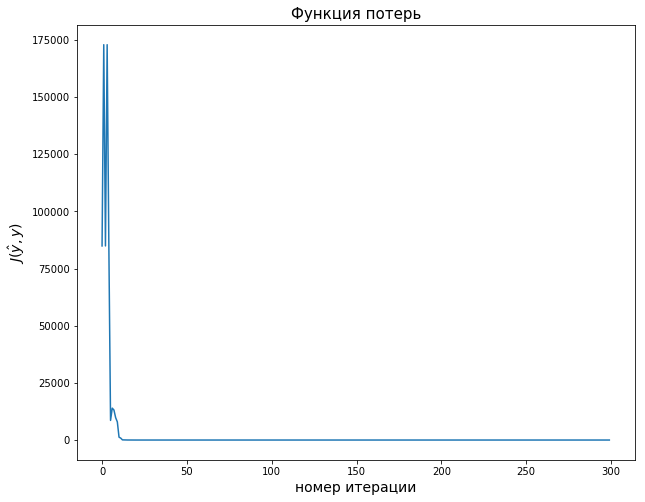

0.956


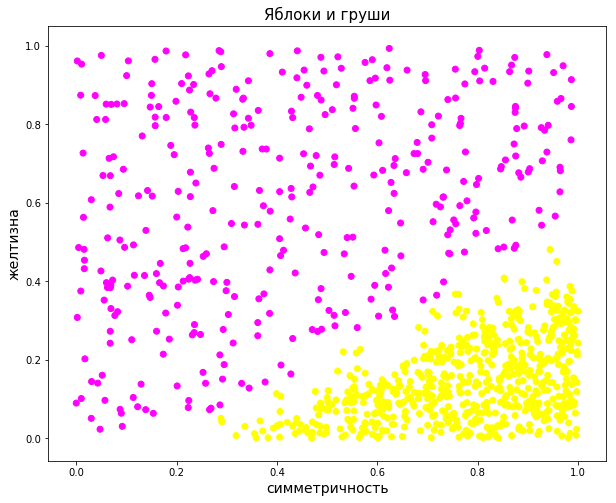

In [222]:
data = pd.read_csv("./data/apples_pears.csv")

X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values  # классы (столбец из нулей и единиц)

w = np.random.random((2, 2))
b = np.random.random(2)
perceptron = Perceptron(w, b)
perceptron.fit(X, y, 300)

plt.figure(figsize=(10, 8))
plt.plot(J_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$J(\hat{y}, y)$', fontsize=14)
plt.show()

print(accuracy_score(perceptron.evaluate(X), y))

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=perceptron.evaluate(X), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show()

Точность получилась не самая лучшая. Возможно, я всё же допустил какую-то ошибку при написании этого нейрона.

In [200]:
data_path = './data/voice.csv'
data = pd.read_csv(data_path)
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)

data = data.sample(frac=1)

X_train = np.array(data.iloc[:int(len(data)*0.7), :-1])  # матрица объекты-признаки
y_train = np.array(data.iloc[:int(len(data)*0.7), -1])  # истинные значения пола (мужчина/женщина)

X_test = data.iloc[int(len(data)*0.7):, :-1]  # матрица объекты-признаки
y_test = data.iloc[int(len(data)*0.7):, -1]  # истинные значения пола (мужчина/женщина)


skp = skPerceptron()
p = Perceptron(np.random.random((2, X_test.shape[1])), np.random.random(2))
skp.fit(X_train, y_train)
_ = p.fit(X_train, y_train, 300)

print('Точность (доля правильных ответов, из 100%) моего перцептрона: ' + str(accuracy_score(p.evaluate(np.array(X_test)), np.array(y_test)) * 100))
print('Точность (доля правильных ответов) перцептрона из sklearn: ' + str(skp.score(X_test, y_test) * 100))

 97%|█████████▋| 291/300 [00:42<00:01,  6.92it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 300/300 [00:43<00:00,  7.01it/s]


Точность (доля правильных ответов, из 100%) моего перцептрона: 50.8937960042
Точность (доля правильных ответов) перцептрона из sklearn: 50.1577287066
